## Imports and setting filepaths based on config

Note that I am running on this an environment called pipinstallenvironment which is a conda environment where I did pip install user. as per the original github code


In [1]:
from pathlib import Path
import sys
import math
from typing import List, Tuple

import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from dotenv import dotenv_values

#import echonet

#Understanding the config file 

config = dotenv_values("videos.env")
print(config)
print(config["LEFT_SEGMENT_DIR"]) 



OrderedDict([('LEFT_SEGMENT_DIR', 'C:/Users/Allis/Documents/MDN/Ultrasound2023/Drive_Results/all-patients'), ('FLIPPED_SEGMENT_DIR', 'C:/Users/Allis/Documents/MDN/Ultrasound2023/Drive_Results/flipped'), ('ECHONET_VIDEO_DIR', 'C:/Users/Allis/Documents/MDN/Ultrasound2023/dynamic/a4c-video-dir'), ('VIDEONAME', '0X685A4B045C95B72A'), ('LV_MASK', 'C:\\Users\\Allis\\Documents\\MDN\\Ultrasound2023\\Drive_Results\\all-patients\\segmentation_masks\\0X685A4B045C95B72A.npy'), ('RV_MASK', 'C:\\Users\\Allis\\Documents\\MDN\\Ultrasound2023\\Drive_Results\\flipped\\segmentation_masks\\0X685A4B045C95B72A.npy')])
C:/Users/Allis/Documents/MDN/Ultrasound2023/Drive_Results/all-patients


In [2]:
from pathlib import Path
import sys
import math
from typing import List, Tuple

import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from dotenv import dotenv_values

#import echonet


config = dotenv_values("videos.env")

# Just some types for us to use in type hints to make dev easier
Point = List[np.intp]
Box = Tuple[Point, Point, Point, Point]
Rectangle = Tuple[Point, Tuple[float, float], float] # [centre, (width, height), angle]

# Directories containing both original and flipped segmentation masks
LEFT_SEGMENTATION_DIR = Path(config["LEFT_SEGMENT_DIR"]) # e.g. LEFT_SEGMENT_DIR="Ultrasound2023\Drive_Results\all-patients in the videos.env file"
LEFT_SEGMENTATION_MASK_DIR = LEFT_SEGMENTATION_DIR / "segmentation_masks" # remember that you have to have run the modified segmentation.py to get this segmentations sub-directory!
FLIPPED_SEGMENTATION_DIR = Path(config["FLIPPED_SEGMENT_DIR"]) # e.g. FLIPPED_SEGMENT_DIR="Ultrasound2023\Drive_Results\flipped"
FLIPPED_SEGMENTATION_MASK_DIR = FLIPPED_SEGMENTATION_DIR / "segmentation_masks"

ECHONET_VIDEO_DIR = Path(config["ECHONET_VIDEO_DIR"]) # e.g. ECHONET_VIDEO_DIR="Ultrasound2023\a4c-videos\a4c-video-dir"

# Can assign these colours to numpy arrays so long as the colours are stored in
# the last axis of the target array (e.g. image.shape =(112, 112, 3), but not
# image.shape = (3, 112, 112)). 
# Just do image[y_vals, x_vals] = MAGENTA
# IMPORTANT: if using within an *opencv* function, you'll want to do 
# COLOUR.tolist() to convert these to python primitives, else opencv complains about
# datatypes
RED = np.array([255, 0, 0])
GREEN = np.array([0, 255, 0])
BLUE = np.array([0, 0, 255])
ORANGE = np.array([255, 165, 0])
LIGHT_GREY = np.array([211, 211, 211])
MAGENTA = np.array([255, 0, 255])
YELLOW = np.array([255, 255, 0])

## Utility functions for us

In [4]:
#Open a normal echonet video 
#open a segmented video 
#open a flipped video

# Import libraries
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Define file path
#for echonet video
# filepath = str("C:/Users/Allis/Documents/MDN/Ultrasound2023/a4c-videos/a4c-video-dir/Videos/0X1A2E9496910EFF5B.AVI")

#for flipped video
# filepath = str("C:/Users/Allis/Documents/MDN/Ultrasound2023/Drive_Results/flipped/videos/0X1C8C0CE25970C40.AVI")

#for regular segmentation video
filepath = str("C:/Users/Allis/Documents/MDN/Ultrasound2023/Drive_Results/all-patients/videos/0X1A5FAE3F9D37794E.AVI")


# Read video file
video = cv2.VideoCapture(filepath)


# Check if video is opened successfully
if video.isOpened():
    # Get video properties
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video.get(cv2.CAP_PROP_FPS)
    print(f"Video width: {width}")
    print(f"Video height: {height}")
    print(f"Video fps: {fps}")

    # Loop through video frames
    while True:
        # Read next frame
        ret, frame = video.read()

        # Break if no more frames
        if not ret:
            break

        # Convert frame from BGR to RGB color space
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Create a named window
        cv2.namedWindow('frame', cv2.WINDOW_NORMAL)

        # Resize the window
        cv2.resizeWindow('frame', 640, 480)

        # Display frame using cv2.imshow()
        cv2.imshow('frame', frame)

        # Wait for a key press or specified delay
        key = cv2.waitKey(int(1000/fps))

        # Break if 'q' key is pressed
        if key == ord('q'):
            break

else:
    print("Error opening video file")

# Release video object
video.release()
cv2.destroyAllWindows() 

Video width: 224
Video height: 224
Video fps: 50.0


In [5]:
import cv2
 
def get_heights(mask: np.ndarray) -> List[int]:
    """
    Returns array of heights of mask for each frame! Height is determined based
    on the highest and lowest (in terms of y values) pixels that are True in the
    given mask.
    """
    frame_indices, row_indices = np.where(mask.any(axis=1)==True)

    heights = []
    for frame_index in range(mask.shape[0]):
        this_frame = frame_indices == frame_index

        if len(row_indices[this_frame]) == 0:
            # print(f"Frame #{frame_index} appears to have no segmentations? Treating this as zero height...")
            heights.append(0)
            continue

        min_row, max_row = (min(row_indices[this_frame]), max(row_indices[this_frame]))
        height = max_row - min_row
        heights.append(height)

    heights = np.array(heights)
    return heights


def get_angle(rect: Rectangle) -> float:
    """
    Converts the angle returned by opencv for a rotated rectangle into a more
    reliable one that doesn't require you to know which sides correspond to 
    "height" and which correspond to "width".

    Returns
    -------
    angle: float
        Angle in degrees in the range of (-90, 90).
    """
    _, (width, height), angle = rect
    if width < height:
        return 0 - angle
    elif height <= width:
        return 90 - angle


BOTTOM_RIGHT = 0
BOTTOM_LEFT = 1
TOP_RIGHT = 2
TOP_LEFT = 3

def find_corner(rect: Rectangle, which: int) ->  Point:
    """
    Returns the coordinates of either the "bottom-right", "bottom-left", 
    "top-left", or "top-right" corner of the given (possible rotated) rectangle.
    The specific corner is chosen with the `which` parameter.

    Note these corner names are a little ambiguous, but were defined based on
    what was most applicable to our needs.
    """
    angle = get_angle(rect)
    box = np.intp(cv2.boxPoints(rect))

    # Critical angle regions are: [-90, -45), [-45, 0], (0, 45), [45, 90) ?
    if (-90 <= angle < -45) or (0 < angle < 45):
        if which == BOTTOM_LEFT:
            return box[3]
        elif which == TOP_LEFT:
            return box[0]
        elif which == TOP_RIGHT:
            return box[1]
        elif which == BOTTOM_RIGHT:
            return box[2]
    elif (-45 <= angle <= 0) or (45 <= angle <= 90):
        if which == BOTTOM_LEFT:
            return box[0]
        elif which == TOP_LEFT:
            return box[1]
        elif which == TOP_RIGHT:
            return box[2]
        elif which == BOTTOM_RIGHT:
            return box[3]


def mask_to_image(mask: np.ndarray, max_val: int = 255) -> np.ndarray:
    """
    Converts a boolean mask array to a pure black and white image. Useful if
    you start with a mask but then want to find contours and perform other image
    analysis on that mask    
    """
    return mask.astype(np.uint8) * max_val


def image_to_mask(image: np.ndarray, threshold: int = 1) -> np.ndarray:
    """
    Converts a black and white image to a boolean mask, selecting every pixel 
    whose intensity is **greater than or equal to the threshold**
    """
    return image >= threshold


def extrapolate_line(p1: Point, p2: Point, frame_height: int, frame_width: int) -> List[Point]:
    """
    Extends a line between the given pair of points for all given x values and
    returns the list of points on this line.
    
    This clips the points for you in case any of the given x values correspond to
    y values outside of the image's borders.
    """
    # Just to be safe, make sure points are in ascending order of x (unless 
    # vertically alligned)
    if p2[0] < p1[0]:
        p1, p2 = p2, p1

    x1, y1 = p1
    x2, y2 = p2

    # Vertical line is special case
    if x1 == x2:
        # Vertical lines are a special case
        ys = np.arange(frame_height)
        xs = np.ones(ys.shape, dtype=np.intp) * x1
    else:
        gradient = (y2 - y1) / (x2 - x1)
        y_intercept = y1 - gradient * x1
        
        # Whether the straight line will be steep or not. If it *is* steep, then that
        # means that a single x value can correspond to multiply y values, due to
        # pixellated nature of the line, and vice versa if it is *not* steep. We
        # therefore need to treat the two steepness cases separately to ensure a
        # fully continuous line.
        is_steep = abs(y2 - y1) > abs(x2 - x1)
        if is_steep:
            # Start with all y values, and determine matching xs
            ys = np.arange(frame_height)
            #    y = mx + c
            # => x = (y - c) / m
            xs = (ys - y_intercept) / gradient
        else:
            # Start with all x values, and determine matching ys
            xs = np.arange(frame_width)
            ys = gradient * xs + y_intercept
    
    # Make sure coordinates are all corect type for opencv indexing
    xs = np.intp(xs)
    ys = np.intp(ys)
    points = list(zip(xs, ys))
    return points


def get_min_area_rect(image: np.ndarray) -> Rectangle:
    """
    Finds the largest contour in the given image, and returns the minimum area
    rectangle that bounds it.

    Returns
    -------
    ((centre_x, centre_y), (width, height), angle)

    """
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #countours are curves or boundaries that connect continious points along the boundary 


    if len(contours) == 0:
        return None

    # Assume we're only interested in max area contour
    areas = [cv2.contourArea(cnt) for cnt in contours]
    max_index = np.argmax(areas)
    biggest_contour = contours[max_index]

    min_area_rect = cv2.minAreaRect(biggest_contour)

    centre, (width, height), angle = min_area_rect
    if angle == 90:
        # Rotate counterclockwise by 90 degrees if angle is 90 degrees
        min_area_rect = (centre, (height, width), 0)

    return min_area_rect


def get_min_area_box(image: np.ndarray) -> Box:
    """
    Similar to get_min_area_rect(), but instead returns the coordinates of the
    box's four corners.
    """
    min_area_rect = get_min_area_rect(image)
    if min_area_rect is None:
        return None
    box = np.intp(cv2.boxPoints(min_area_rect))
    
    return box


def perpendicular_distance_to_line(line: List[List[int]], point: List[int]) -> float:
    """
    Returns the perpendicular distance from a straight line to a given point.

    Parameters
    ----------
    line: List[List[int]]
        `line` is a *pair* of points, where each point contains a single x and y
        value.
    point: List[int]
        A pair of x and y values.
    """
    (x1, y1), (x2, y2) = line
    x3, y3 = point

    if x2 == x1:
        return abs(x1 - x3)

    m = (y2 -y1) / (x2 - x1)
    a = -1
    b = 1 / m
    c = x1 - y1 / m

    d = abs(a * x3 + b * y3 + c) / math.sqrt(a**2 + b**2)
    return d


def crop_mask_with_line(mask: np.ndarray, line: List[Point], below=False, above=False, left=False, right=False):
    """
    Sets all pixels to some side(s) of the given line to False in the given 
    mask, effectively cropping the mask with an arbitrary line.

    Note that the given line can technically have points that are out of bounds
    of the frame. This is actually needed so we can crop based on particularly
    steep lines (e.g. the LV's septum border, which likely only takes up a few
    x values in the actual frame). 

    This modifies the given `mask` in-place.
    """
    mask_height, mask_width = mask.shape

    for x, y in line:
        y_is_valid = (0 <= y < mask_height)
        x_is_valid = (0 <= x < mask_width)

        if below and x_is_valid:
            y = min(y, mask_height-1)
            mask[y:, x] = False
        if above and x_is_valid:
            y = max(y, 0)
            mask[:y, x] = False
        if left and y_is_valid:
            x = min(x, mask_width-1)
            mask[y, :x] = False
        if right and y_is_valid:
            x = max(x, 0)
            mask[y, x:] = False


def crop_line_to_frame(line: List[Point], frame_height: int, frame_width: int) -> List[Point]:
    """
    Returns a subset of the given `line` that fits within the given frame 
    dimensions. This is useful if you have a line that potentially goes beyond 
    the frame, and you want to show that line using opencv (which will complain
    about index errors if any given points are out of bounds).
    """
    # We could probs use cv2.clipLine(), but that only returns the two endpoints,
    # so we'd still have to find all points in between anyway!
    cropped_line = []
    for point in line:
        x, y = point
        if (0 <= x < frame_width) and (0 <= y < frame_height):
            cropped_line.append(point)

    return cropped_line


def clip_and_draw_line(frame: np.ndarray, line: List[Point], colour: Tuple[int, int, int]):
    """
    Helper function to draw the given line on the given frame, making sure to clip
    the line to the frame to avoid any out-of-bounds errors.
    """
    frame_height, frame_width, _ = frame.shape
    img_rect = (0, 0, frame_width, frame_height)
    in_bounds, point1, point2 = cv2.clipLine(img_rect, line[0], line[-1])
    
    cv2.line(frame, point1, point2, colour)

#This takes in an input of segmentation masks which is just an array of numerical data 
#The array represents the masks using 0's and 1's. 1's occur where the mask is present. They have a shape of 57,112,112                                                                  
def is_a2c(left_segmentation_masks, right_segmentation_masks):
    #This uses the '&' symbol which is a bitwise operator that take in 2 inputs and output 1, if both inputs are 1. This takes the intersection masks. 
    intersection = left_segmentation_masks & right_segmentation_masks
    #Because it's the intersection, the only masks left are the ones where 1 is present in both, returning an intersection mask between left and right segmentations. 

    #.sum() returns the sum of all the elements in a numpy array. The axis = ... allows you to dictate which parts of the array you're applying the operation to
    #Doing axis = (1,2) adds the total values of 1's for each frame where the masks intersect.  
    intersection_counts = intersection.sum(axis=(1, 2))

    #What this does is if a 1 exists between either of the masks, then a 1 will be outputted. So it's a union or a combined mask of left and right.     
    union = left_segmentation_masks | right_segmentation_masks

    #And by doing this, we add the total value of 1's in each frame where we have the combined left and right masks. 
    union_counts = union.sum(axis=(1, 2))

    #ious stands for intersections over union scores. 
    #the / just divides the number of intersections with the number of unions. 
    # So you can think of this as the number of intersected values of the left and right being divided by the total combined area of the left and right segmentations.  
    # This gives this value for each frame. 
    ious = intersection_counts / union_counts
    
    #So if we combine these, and we find that the average ious are greater than 0.5
    #We can interpret this by if the intersection of the left and the right makes up more than the combined area of left and right masks
    #then it is a2c, because the intersection is way too large. Since we are using flipped, this would cause a large overlap as 
    # A flipped video would cause masks that just occur on the same space, as opposed to a4c videos which would be way less than 0.5, as these would be segregated   
    return np.mean(ious) > 0.5

In [111]:
#TESTING axis on numpy values. 
#note: do not use array = np.array() it gives a type error because the variable array is already taken. 

#testing axis = 1 , 2 etc in numpy 
import numpy as np 

test = np.array([[1, 2, 3, 4, 5], [6,7,8,9,10]])
#print(test)

# print(test.shape)
#outputs 2,5 as there are 2 arrays each containing 5 items. 

# something = test.sum()
# print(something)
#prints 55 which is the total sum of all the arrays

#This adds along the columns 
# something1 = test.sum(axis = 0)
# print(something1)

# something2 = test.sum(axis = 1)
# print(something2)
#This adds along the rows 


# something3 = test.sum(axis = 2)
# print(something3)
#This doesn't work because axis 2 does operations along the 2D planes, which requires 3 dimensional shape ie. a 3rd shape value.   

#we can try axis = 2 on this one instead.
test2 = np.array([[[1,2], [3,4]],[[6,7], [8,9]]])

# print(test2.shape) 
#outputs a shape of (2,2,2)

# something10 = test2.sum(axis = 0)
# print(something10)
#This takes our array and kinda structures it like this now 
[[[1,2], [3,4]],
 [[6,7], [8,9]]]
#and then it adds along these columns down ie. 1 + 6, 2 + 7, 8 + 3, 4 + 9

# something11 = test2.sum(axis = 1)
# print(something11)
#this takes our array and structures it like this, but adds it by rows.  
[[[1,2], [3,4]], #it adds 1 and 3, and then 2 and 4. 
 [[6,7], [8,9]]] #it adds 6 and 8 and then 7 and 9. 

# something12 = test2.sum(axis = 2)
# print(something12)
#This adds between the most inner arrays, adding 1 and 2, 3 and 4, 6 and 7, 8 and 9
output = [[ 3 , 7], [13 , 17]]

#now what does axis = (1,2) do? 
something13 = test2.sum(axis = (1,2))
print(something13)
[[[1,2], [3,4]],[[6,7], [8,9]]]
#This adds the second inner array. 1 + 2 + 3 + 4 and etc..


[10 30]


[[[1, 2], [3, 4]], [[6, 7], [8, 9]]]

## Load sample echonet video and its corresponding raw left and right segmentations

In [6]:
import echonet 

# Reload here so we can just change the VIDEONAME in .env without having to 
# go back and rerun top cell
# Add this configuration 
config = dotenv_values("videos.env")
VIDEONAME = config["VIDEONAME"] # e.g. VIDEONAME="0X1ACB73BE8C1F2C0C" - This video doesn't exist in the flipped and the all videos and the original videos. 
#This might be the better one: 0X5B9C0EEB93E0BE10 ... nvm it doens't have it's flipped segmentation masks file... sigh. Might be better running segmentation myself. 
#The flipped segmentation masks drive only has 25 masks. 
# try this instead: 0X685A4B045C95B72A

LEFT_SEGMENTATION_MASK_FP = LEFT_SEGMENTATION_MASK_DIR / f"{VIDEONAME}.npy" #these are just the masks
FLIPPED_SEGMENTATION_MASK_FP = FLIPPED_SEGMENTATION_MASK_DIR / f"{VIDEONAME}.npy" #These are just the masks
ECHONET_VIDEO_FP = ECHONET_VIDEO_DIR / f"Videos/{VIDEONAME}.avi" #This is the actual video 

left_segmentation_masks = np.load(LEFT_SEGMENTATION_MASK_FP)
flipped_segmentation_masks = np.load(FLIPPED_SEGMENTATION_MASK_FP) #These are the masks that were created for the right ventricle 
right_segmentation_masks = np.flip(flipped_segmentation_masks, -1) # Flip back to original orientation as these were initially flipped to be on the left side. so now they appear on the right ventricle side
# Remove any pixels in right segmentation that are already in left segmentation
# right_segmentation_masks = right_segmentation_masks & ~left_segmentation_masks

#The mask_to_image comes from above. 
#This converts a mask to pure black and white 
left_segmentations = mask_to_image(left_segmentation_masks)
right_segmentations = mask_to_image(right_segmentation_masks)

#load video does returns: A np.ndarray with dimensions (channels=3, frames, height, width). 
# The values will be uint8's ranging from 0 to 255.
# so echonet_video is a numpy array containing the video frames 
echonet_video = echonet.utils.loadvideo(str(ECHONET_VIDEO_FP))
echonet_video = echonet_video.transpose((1, 2, 3, 0)) # Put colour axis at end for easier colouring of pixels

#This just gets the shape values from that echonet video? 
num_frames, frame_height, frame_width, num_channels = echonet_video.shape 

#We did not combine the echonet_videos with the masks in this cell. 

In [7]:
#What are the shapes of the segmentation masks? 
print(f'left segmentation mask shape: {left_segmentation_masks.shape}') #(57, 112, 112) [the first isn't always 80, it depends what video you're using. this is frames and some vids are just longer.]
#This prints the following shape (57, 112, 112) [the first isn't always 80, it depends what video you're using. this is frames and some vids are just longer.]
#this is a 3 dimensional array and can be thought of a 57(or 80 depending on your frame count) 2D arrays stacked on each other where each 2D array is 112 x 112. 
print('')
print(f'left_segmentations (images) shape :{left_segmentations.shape}')
print('')

print(f'echonet video shape :{echonet_video.shape}')
print('')



left segmentation mask shape: (80, 112, 112)

left_segmentations (images) shape :(80, 112, 112)

echonet video shape :(80, 112, 112, 3)



In [8]:
#This is a list containing lists. Each inner list is trues and falses of length 112. 
print(f' This is left_segmentations_masks[0] {left_segmentation_masks[0]}')

 This is left_segmentations_masks[0] [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [9]:
#This is a single list containing just falses (it's the first frame). 
print(f' This is left_segmentations_masks[0][0] {left_segmentation_masks[0][0]}')

 This is left_segmentations_masks[0][0] [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]


In [10]:
#you can see some trues here which indicate where parts of the 50th frame contain the actual left segmentation mask (true represents a pixel of the mask, false is the rest of the image/frame) 
print(f' This is left_segmentations_masks[0][50] {left_segmentation_masks[0][50]}')

 This is left_segmentations_masks[0][50] [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]


In [11]:
#Note that left_segmentations has had the mask_to_image() applied to it. This turns the trues and falses into 1's and 0's
print(f'left_segmentations: {left_segmentations}')
print('')
#now a single true value is made into 255 only. 
print(f'left_segmentations[0][50]: {left_segmentations[0][50]}')

left_segmentations: [[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]

left_segmentations[0][50]: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0

In [12]:

#Understanding echonet
print(f'echonet_video.shape: {echonet_video.shape}')
print('')
print("""This is a 4D array. It's structure looks like this: 
[
    [
        [
            [1,2,3], RGB values    
            [4,5,6]
            .
            112    
        ]
        .
        112
    ]
    .
    80 
]
""" )
print('')
print(f'echonet_video[0][0][0] shows a single array of 3 values(RGB): {echonet_video[0][50][50]}')
print('')
print(f'This is the actual echonet_video representation: {echonet_video}')




echonet_video.shape: (80, 112, 112, 3)

This is a 4D array. It's structure looks like this: 
[
    [
        [
            [1,2,3], RGB values    
            [4,5,6]
            .
            112    
        ]
        .
        112
    ]
    .
    80 
]


echonet_video[0][0][0] shows a single array of 3 values(RGB): [31 31 31]

This is the actual echonet_video representation: [[[[ 0  0  0]
   [ 0  0  0]
   [ 0  0  0]
   ...
   [ 0  0  0]
   [ 0  0  0]
   [ 0  0  0]]

  [[ 0  0  0]
   [ 0  0  0]
   [ 0  0  0]
   ...
   [ 0  0  0]
   [ 0  0  0]
   [ 0  0  0]]

  [[ 0  0  0]
   [ 0  0  0]
   [ 0  0  0]
   ...
   [ 0  0  0]
   [ 0  0  0]
   [ 0  0  0]]

  ...

  [[24 24 24]
   [ 6  6  6]
   [21 21 21]
   ...
   [ 0  0  0]
   [ 0  0  0]
   [ 0  0  0]]

  [[ 8  8  8]
   [ 5  5  5]
   [ 0  0  0]
   ...
   [ 0  0  0]
   [ 0  0  0]
   [ 1  1  1]]

  [[ 0  0  0]
   [ 1  1  1]
   [ 0  0  0]
   ...
   [ 0  0  0]
   [ 0  0  0]
   [ 0  0  0]]]


 [[[ 0  0  0]
   [ 0  0  0]
   [ 0  0  0]
   ...
   [

In [13]:
#simply check if it's an a2c, this says it's not a2c for 0X685A4B045C95B72A 
is_a2c(left_segmentation_masks, right_segmentation_masks)

False

## Define key variables related to LV
These are fine to define once and reuse over and over because we assume the LV segmentations are practically perfect, meaning we will never change them. This is in contrast to the RV segmentations, which we will regularly modify throughout this notebook.

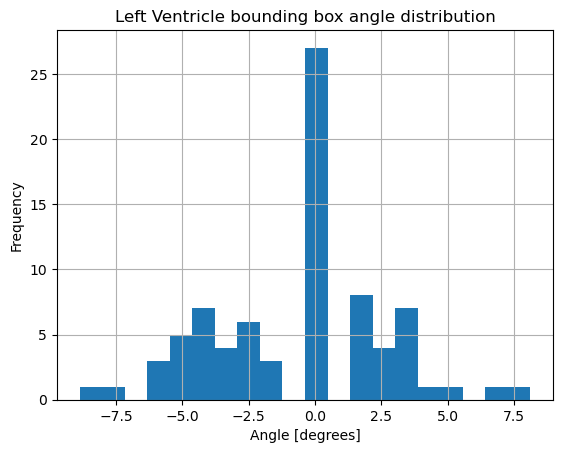

In [18]:
# Define LV boxes and rectangles
LV_boxes = [get_min_area_box(left_segmentation) for left_segmentation in left_segmentations]
LV_rects = [get_min_area_rect(left_segmentation) for left_segmentation in left_segmentations]
LV_septum_borders = [[find_corner(rect, BOTTOM_LEFT), find_corner(rect, TOP_LEFT)] for rect in LV_rects]
LV_angles = [get_angle(rect) for rect in LV_rects]

plt.hist(LV_angles, bins=20)
plt.title("Left Ventricle bounding box angle distribution")
plt.xlabel("Angle [degrees]")
plt.ylabel("Frequency")
plt.grid()

In [20]:
#displaying a single video by itself 
echonet_video = echonet.utils.loadvideo(str(ECHONET_VIDEO_FP)) 
print (echonet_video.shape)

echonet_video = np.transpose(echonet_video, (1, 2, 3, 0))
print(echonet_video.shape)

for frame in echonet_video:
    
    cv2.imshow('Video', frame)
    
    keypress = cv2.waitKey(50) & 0xFF
    if keypress == ord('q'):
        break

cv2.destroyAllWindows()



(3, 80, 112, 112)
(80, 112, 112, 3)


In [21]:
#Can I view these boxes? 
#get that show_video function from lex's code 
#Just try to display the video only for now I guess. 
RED = np.array([255, 0, 0]) 
config = dotenv_values("videos.env")
LV_masks = np.load(config["LV_MASK"])
RV_masks = np.load(config["RV_MASK"])
echonet_video = echonet.utils.loadvideo(str(ECHONET_VIDEO_FP)) #This transforms the video into an np.ndarray 

WINDOW = f"Segmentation: {config['VIDEONAME']}.avi"
cv2.namedWindow(WINDOW, cv2.WINDOW_NORMAL)

i = 0
is_playing = True

min_y = 1000
max_y = -1000

echonet_video = np.transpose(echonet_video, (1, 2, 3, 0)) #shape is (80, 112, 112, 3)

try:
    while True:
        if i >= num_frames:
            i = 0
        elif i < 0:
            i = num_frames - 1

        # print(i)

        # Copy data for this particular frame
        frame = echonet_video[i].copy()
        LV_mask = LV_masks[i].copy()
        RV_mask = RV_masks[i].copy()
        
        ######## SEGMENTATIONS
        #The issue here was that it didn't like the colors in array form, but rather as lists. 
        frame[LV_mask] = RED
        frame[RV_mask] = BLUE

        cv2.imshow(WINDOW, frame)

        keypress = cv2.waitKey(50) & 0xFF
        if keypress == ord('q'):
            break
        elif keypress == ord(' '):
            is_playing = not is_playing
        elif keypress == ord('a'):
            i -= 1
        elif keypress == ord('d'):
            i += 1
        else:
            if is_playing:
                i += 1

finally:
    cv2.destroyAllWindows() 

## Trim RV segmentation based on LV bounding box
If you extend the bottom of the LV's bounding box (which should roughly be in line with the mitral valve, i.e. near-horizontal), then assume that the tricuspid valve is somewhere along that line. Therefore, any of the RV segmentation that appears *below* that line must be incorrectly including some of the RA, 

In [46]:
# Trim RV segmentations based on LV bounding box
right_segmentations = np.zeros(shape=right_segmentations.shape, dtype=right_segmentations.dtype)
# mask_right_segmentations = np.zeros(shape=right_segmentations.shape, dtype=right_segmentations.dtype)

valve_cutoff_points_list = []
apex_cutoff_points_list = []
LV_septum_border_cutoff_points_list = []

cutoff_x = np.intp(np.arange(0, frame_width))

for i, (LV_box, LV_rect, right_segmentation_mask) in enumerate(zip(LV_boxes, LV_rects, right_segmentation_masks)):
    top_left_LV = find_corner(LV_rect, TOP_LEFT)
    top_right_LV = find_corner(LV_rect, TOP_RIGHT)
    bottom_left_LV = find_corner(LV_rect, BOTTOM_LEFT)
    bottom_right_LV = find_corner(LV_rect, BOTTOM_RIGHT)

    # Remove any points from RV segmentation that seem to be *below* tricuspid valve (e.g. in RA)
    valve_cutoff_points = extrapolate_line(bottom_left_LV, bottom_right_LV, frame_height=frame_height, frame_width=frame_width)
    valve_cutoff_points_list.append(valve_cutoff_points)
    crop_mask_with_line(mask=right_segmentation_mask, line=valve_cutoff_points, below=True)

    # Remove any points from RV segmentation that seem to be *above* heart's apex
    apex_cutoff_points = extrapolate_line(top_left_LV, top_right_LV, frame_height=frame_height, frame_width=frame_width)
    apex_cutoff_points_list.append(apex_cutoff_points)
    crop_mask_with_line(mask=right_segmentation_mask, line=apex_cutoff_points, above=True)

    # Remove any points from RV segmentation that seem to be *right* of the LV's inner edge/septum wall
    LV_septum_border_cutoff_points = extrapolate_line(bottom_left_LV, top_left_LV, frame_height=frame_height, frame_width=frame_width)
    LV_septum_border_cutoff_points_list.append(LV_septum_border_cutoff_points)
    crop_mask_with_line(mask=right_segmentation_mask, line=LV_septum_border_cutoff_points, right=True)

    # mask_right_segmentations[i] = right_segmentation_mask
    right_segmentations[i] = mask_to_image(right_segmentation_mask)



In [47]:
RV_masks = np.load(config["RV_MASK"])
RV_masks[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [69]:
masked_right_segmentations = np.zeros(shape=right_segmentations.shape, dtype=right_segmentations.dtype)
for i in enumerate(right_segmentations):
    masked_right_segmentations[i] = image_to_mask(right_segmentations[i]) 
    print(i)


#why can't I convert all of the images into masks here

(0, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
(1, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
(2, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
(3, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
(4, array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       .

In [68]:
masked_right_segmentations[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [66]:
masked_right_segmentations = np.zeros(shape=right_segmentations[0].shape, dtype=right_segmentations[0].dtype)
masked_right_segmentations = image_to_mask(right_segmentations[0])
masked_right_segmentations


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [35]:
### display the trimmings that have been done using the bounding box 

#Can I view these boxes? 
#get that show_video function from lex's code 
#Just try to display the video only for now I guess. 
config = dotenv_values("videos.env")
LV_masks = np.load(config["LV_MASK"])
RV_masks = np.load(config["RV_MASK"])
echonet_video = echonet.utils.loadvideo(str(ECHONET_VIDEO_FP)) #This transforms the video into an np.ndarray 

new_RV_masks = 

WINDOW = f"Segmentation: {config['VIDEONAME']}.avi"
cv2.namedWindow(WINDOW, cv2.WINDOW_NORMAL)

i = 0
is_playing = True

min_y = 1000
max_y = -1000

echonet_video = np.transpose(echonet_video, (1, 2, 3, 0)) #shape is (80, 112, 112, 3)

try:
    while True:
        if i >= num_frames:
            i = 0
        elif i < 0:
            i = num_frames - 1

        # print(i)

        # Copy data for this particular frame
        frame = echonet_video[i].copy()
        LV_mask = LV_masks[i].copy()
        RV_mask = RV_masks[i].copy()
        
        ######## SEGMENTATIONS
        #The issue here was that it didn't like the colors in array form, but rather as lists. 
        frame[LV_mask] = RED
        frame[RV_mask] = BLUE

        cv2.imshow(WINDOW, frame)

        keypress = cv2.waitKey(50) & 0xFF
        if keypress == ord('q'):
            break
        elif keypress == ord(' '):
            is_playing = not is_playing
        elif keypress == ord('a'):
            i -= 1
        elif keypress == ord('d'):
            i += 1
        else:
            if is_playing:
                i += 1

finally:
    cv2.destroyAllWindows() 

IndexError: index 255 is out of bounds for axis 0 with size 112

## Only select largest contiguous region for each frame's right segmentation.
This eliminates small, disconnected blobs that are usually well outside of the RV. 

In [ ]:
# Only include largest contour of right segmentation for each frame. This removes
# any smaller, disconnected blobs
right_segmentations_copy = right_segmentations.copy()
right_segmentations = np.zeros(right_segmentations.shape, dtype=right_segmentations.dtype)
for i, right_segmentation in enumerate(right_segmentations_copy):
    right_contours, hierarchy = cv2.findContours(right_segmentation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(cnt) for cnt in right_contours]
    max_index = np.argmax(areas)
    biggest_contour = right_contours[max_index]

    biggest_right_segmentation = np.zeros(right_segmentation.shape)
    biggest_right_segmentation = cv2.drawContours(biggest_right_segmentation, [biggest_contour], -1, 255, -1)
    right_segmentations[i] = biggest_right_segmentation

# Update masks too, would be nicer to have these masks and images automatically linked though!
right_segmentation_masks = image_to_mask(right_segmentations)

ValueError: attempt to get argmax of an empty sequence

## Determine septum width and RV areas

In [ ]:
# Calculate RV areas
# Since we have already eliminated all but the largest contour, we simply always
# use hardcoded index of 0 to access it!
# Then extra index zero for contours because of opencv's return values
RV_contours_list = [cv2.findContours(frame, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0][0] for frame in right_segmentations]
RV_areas = [cv2.contourArea(contour) for contour in RV_contours_list]

# Find septum widths
septum_widths = []

for i, (right_segmentation, LV_line) in enumerate(zip(right_segmentations, LV_septum_borders)):
    print(i)
    RV_rect = get_min_area_rect(right_segmentation)
    RV_bottom_right = find_corner(RV_rect, BOTTOM_RIGHT)

    x3, y3 = RV_bottom_right
    # frame[y3:y3+2, x3:x3+2] = ORANGE
    septum_width = perpendicular_distance_to_line(LV_line, RV_bottom_right)
    septum_widths.append(septum_width)
    # print(f"Septum: {septum_width}")

print(f"Mean septum width: {np.mean(septum_widths)} +/- {np.std(septum_widths)}")
RV_boxes = [get_min_area_box(right_segmentation) for right_segmentation in right_segmentations]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
Mean septum width: 5.5408694172177695 +/- 2.1507709734494096


## Remove ultrasound borders

In [ ]:
left_ultrasound_corner = (1, 67)
top_ultrasound_corner = (62, 6)
ultrasound_left_line = extrapolate_line(left_ultrasound_corner, top_ultrasound_corner, frame_height, frame_width)
for s in right_segmentation_masks:
    crop_mask_with_line(s, ultrasound_left_line, above=True)

# Repeat for right side of ultrasound
right_ultrasound_corner = (111, 58)
top_ultrasound_corner = (63, 6)
ultrasound_right_line = extrapolate_line(right_ultrasound_corner, top_ultrasound_corner, frame_height, frame_width)
for s in right_segmentation_masks:
    crop_mask_with_line(s, ultrasound_right_line, above=True)
right_segmentations = mask_to_image(right_segmentation_masks)

## Remove septum from RV segmentation

In [ ]:
# Use average estimated septum width and translate the LV segmentation's inner
# edge by that amount to guess the right edge of the RV.
mean_septum_width = np.mean(septum_widths)

RV_boxes = []
RV_lines = []
for LV_box, LV_rect, LV_line, right_segmentation_mask, right_segmentation in zip(LV_boxes, LV_rects, LV_septum_borders, right_segmentation_masks, right_segmentations):
    LV_angle = get_angle(LV_rect)
    
    # Since we translate points *left*, and not necessarily perpendicular to LV
    # line, we include factor of sin(angle)
    # translate_x = mean_septum_width / math.sin(math.radians(LV_angle))
    translate_x = mean_septum_width * math.cos(math.radians(LV_angle))
    RV_line = [point.copy() for point in LV_line]
    for point in RV_line:
        point[0] -= translate_x

    RV_lines.append(RV_line)

    RV_box = get_min_area_box(right_segmentation)
    # Just in case we need to access this later
    RV_boxes.append(RV_box)

    # Now remove any pixels in RV segmentation that go beyond its expected inner
    # edge
    # Note this is a greedier "right cutoff" than before, should probs just name this better!
    right_cutoff_points = extrapolate_line(RV_line[0], RV_line[1], frame_height=frame_height, frame_width=frame_width)
    crop_mask_with_line(right_segmentation_mask, right_cutoff_points, right=True)
    # for x, y in right_cutoff_points:
    #     right_segmentation_mask[:y, x] = False

# Update RV segmentation *images* based on these new masks
right_segmentations = mask_to_image(right_segmentation_masks)

(array([64.,  0.,  1.,  4., 18., 18., 13., 21., 21., 13., 15., 12.,  1.,
         4.,  2.,  5.,  2.,  4.,  1.,  1.]),
 array([ 0.        ,  0.53098259,  1.06196518,  1.59294777,  2.12393036,
         2.65491295,  3.18589554,  3.71687813,  4.24786072,  4.77884331,
         5.3098259 ,  5.84080849,  6.37179108,  6.90277367,  7.43375626,
         7.96473885,  8.49572144,  9.02670403,  9.55768661, 10.0886692 ,
        10.61965179]),
 <BarContainer object of 20 artists>)

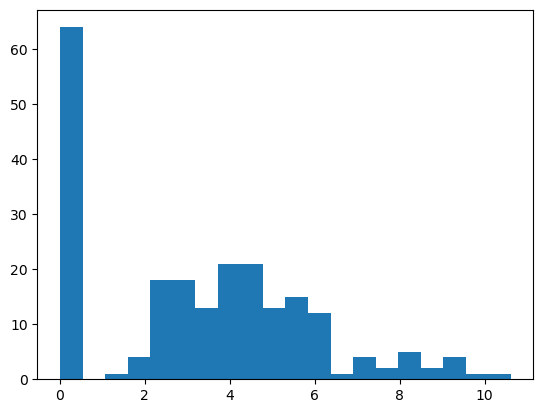

In [ ]:
plt.hist(LV_angles, bins=20)

## Replace frames with too-small RV with nearby, better segmentations

In [ ]:
RV_areas = np.array(RV_areas)
mean_RV_area = np.mean(RV_areas)
std_RV_area = np.std(RV_areas)

z = 1.5
small_RV_indices = np.where(~((mean_RV_area - z * std_RV_area < RV_areas) & (RV_areas < mean_RV_area + z * std_RV_area)))[0]
print(f"Found {len(small_RV_indices)} frames with suspiciously small area")

for i, area in enumerate(RV_areas):
    is_bad_area = not (mean_RV_area - z * std_RV_area < area < mean_RV_area + z * std_RV_area)
    if not is_bad_area:
        continue
    
    offset = 1
    while True:
        left_i = i - offset
        if left_i >= 0 and (mean_RV_area - z * std_RV_area < RV_areas[left_i] < mean_RV_area + z * std_RV_area):
            print(f"Changing frame #{i}'s RV segmentation to that of #{left_i} (offset={offset})")
            right_segmentation_masks[i] = right_segmentation_masks[left_i]
            RV_areas[i] = RV_areas[left_i]
            break

        right_i = i + offset
        if right_i < num_frames and (mean_RV_area - z * std_RV_area < RV_areas[right_i] < mean_RV_area + z * std_RV_area):
            print(f"Changing frame #{i}'s RV segmentation to that of #{right_i} (offset={offset})")
            right_segmentation_masks[i] = right_segmentation_masks[right_i]
            RV_areas[i] = RV_areas[right_i]
            break

        offset += 1

right_segmentations = mask_to_image(right_segmentation_masks)

Found 24 frames with suspiciously small area
Changing frame #9's RV segmentation to that of #8 (offset=1)
Changing frame #10's RV segmentation to that of #9 (offset=1)
Changing frame #11's RV segmentation to that of #10 (offset=1)
Changing frame #12's RV segmentation to that of #11 (offset=1)
Changing frame #13's RV segmentation to that of #12 (offset=1)
Changing frame #14's RV segmentation to that of #13 (offset=1)
Changing frame #15's RV segmentation to that of #14 (offset=1)
Changing frame #51's RV segmentation to that of #50 (offset=1)
Changing frame #52's RV segmentation to that of #51 (offset=1)
Changing frame #56's RV segmentation to that of #55 (offset=1)
Changing frame #57's RV segmentation to that of #56 (offset=1)
Changing frame #111's RV segmentation to that of #110 (offset=1)
Changing frame #113's RV segmentation to that of #112 (offset=1)
Changing frame #114's RV segmentation to that of #113 (offset=1)
Changing frame #130's RV segmentation to that of #129 (offset=1)
Chang

In [ ]:
def get_TAPSE(annulus):
    # Find frame with largest RV segmentation, then use its bottom-left corner to do TAPSE stuff...
    largest_RV_index = np.argmax(RV_areas)
    # print(f"Using {largest_RV_index + 1} frame for TAPSE")
    # largest_RV_box = get_min_area_box(right_segmentations[largest_RV_index])
    largest_RV_rect = get_min_area_rect(right_segmentations[largest_RV_index])
    # annulus = find_corner(largest_RV_rect, BOTTOM_LEFT)
    # annulus = (annulus[0] - 5, annulus[1])
    top_right_RV = find_corner(largest_RV_rect, TOP_RIGHT)
    top_right_RV = (top_right_RV[0] - 5, top_right_RV[1])
    # top_mid_RV = (np.intp(np.mean([top_left_RV[0], top_right_RV[0]])), np.intp(np.mean([top_left_RV[1], top_right_RV[1]])))

    TAPSE_line = extrapolate_line(annulus, top_ultrasound_corner, frame_height=frame_height, frame_width=frame_width)

    TAPSE_line_cropped = crop_line_to_frame(TAPSE_line, frame_height, frame_width)
    # echonet_video_grey = cv2.cvtColor(echonet_video, cv2.COLOR_BGR2GRAY)

    TAPSE_cross_sections = []
    for frame in echonet_video:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        TAPSE_cross_section = []
        for x, y in TAPSE_line_cropped:
            # print(frame[y, x])
            TAPSE_cross_section.append(frame[y, x])
            # echonet_video[0].shape
        TAPSE_cross_sections.append(TAPSE_cross_section)

    TAPSE_cross_sections = np.array(TAPSE_cross_sections)
    TAPSE_cross_sections = TAPSE_cross_sections.transpose((1, 0))
    return TAPSE_line, TAPSE_cross_sections

# TAPSE_line, TAPSE_cross_sections = get_TAPSE()
# plt.imshow(TAPSE_cross_sections, cmap='gray', vmin=0, vmax=255)
# plt.show()

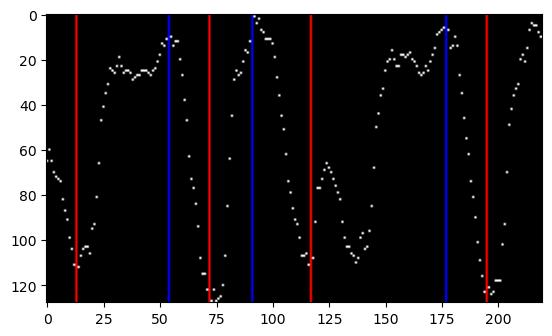

In [ ]:
import scipy

LV_areas = left_segmentation_masks.sum(axis=(1,2))
LV_area_image = np.zeros((128, num_frames, 3), dtype=np.uint8)

min_area, max_area = LV_areas.min(), LV_areas.max()
trim_min = sorted(LV_areas)[round(len(LV_areas) ** 0.05)]
trim_max = sorted(LV_areas)[round(len(LV_areas) ** 0.95)]
trim_range = trim_max - trim_min
diastole = scipy.signal.find_peaks(LV_areas, distance=20, prominence=(0.50 * trim_range))[0]
systole = scipy.signal.find_peaks(-LV_areas, distance=20, prominence=(0.50 * trim_range))[0]

LV_areas = np.uint8((LV_areas - min_area) / (max_area - min_area) * 127)

for i, area in enumerate(LV_areas):
    LV_area_image[127-area, i] = (255, 255, 255)

for s in systole:
    LV_area_image[:, s] = RED

for d in diastole:
    LV_area_image[:, d] = BLUE

plt.imshow(LV_area_image)

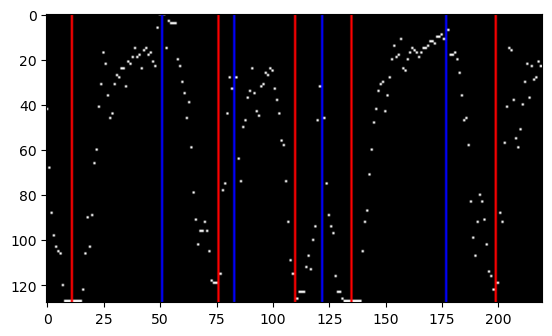

In [ ]:
RV_areas = right_segmentation_masks.sum(axis=(1,2))
RV_area_image = np.zeros((128, num_frames, 3), dtype=np.uint8)

min_area, max_area = RV_areas.min(), RV_areas.max()
trim_min = sorted(RV_areas)[round(len(RV_areas) ** 0.05)]
trim_max = sorted(RV_areas)[round(len(RV_areas) ** 0.95)]
trim_range = trim_max - trim_min
diastole = scipy.signal.find_peaks(RV_areas, distance=20, prominence=(0.50 * trim_range))[0]
systole = scipy.signal.find_peaks(-RV_areas, distance=20, prominence=(0.50 * trim_range))[0]

RV_areas = np.uint8((RV_areas - min_area) / (max_area - min_area) * 127)

for i, area in enumerate(RV_areas):
    RV_area_image[127-area, i] = (255, 255, 255)

for s in systole:
    RV_area_image[:, s] = RED

for d in diastole:
    RV_area_image[:, d] = BLUE

plt.imshow(RV_area_image)

In [ ]:
systole

array([ 54,  91, 177])

## Display segmentation (and whatever else we want) on top of original ultrasound video

In [ ]:
WINDOW = "Mask"
annulus = (10, 10)
TAPSE_thresh = 0

def onclick(event, x, y, flags, param):
    global annulus
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"({x}, {y})")
        annulus = (int(x), int(y))


def onchange(new_thresh):
    global TAPSE_thresh
    TAPSE_thresh = new_thresh

cv2.namedWindow(WINDOW, cv2.WINDOW_NORMAL)
cv2.namedWindow("TAPSE", cv2.WINDOW_NORMAL)
cv2.namedWindow("LV area", cv2.WINDOW_NORMAL)
cv2.namedWindow("RV area", cv2.WINDOW_NORMAL)
cv2.setMouseCallback(WINDOW, onclick)
cv2.createTrackbar("slider", "TAPSE", 0, 255, onchange)

i = 0
is_playing = True

min_y = 1000
max_y = -1000
try:
    while True:
        if i >= num_frames:
            i = 0
            print("Video looped!")
        elif i < 0:
            i = num_frames - 1

        # i = 51

        # Copy data for this particular frame
        frame = echonet_video[i].copy()
        left_segmentation_mask = left_segmentation_masks[i].copy()
        left_segmentation = left_segmentations[i].copy()
        right_segmentation_mask = right_segmentation_masks[i].copy()
        right_segmentation = right_segmentations[i].copy()

        # this_area = RV_areas[i]
        # LV_line = LV_lines[i]
        # RV_line = RV_lines[i]
        LV_box = LV_boxes[i]
        # LV_rect = LV_rects[i]
        # LV_angle = get_angle(LV_rect)
        # print(f"{LV_angle:.2f}: {LV_box}")
        # RV_box = RV_boxes[i]
        # RV_box = get_min_area_box(right_segmentation)
        # RV_rect = get_min_area_rect(right_segmentation)
        # RV_angle = get_angle(RV_rect)
        # print(f"{RV_angle:.2f}: {RV_box}: {RV_rect}")

        # 
        # if i > 0: 
        #     prev_area = RV_areas[i - 1]
        #     growth = this_area / prev_area
            # print(f"RV Area growth: {growth:.2f}")
            # if growth > 1.2:
            #     frame[:10, :] = ORANGE

        RV_box = get_min_area_box(right_segmentation)
        # Add any drawings to the ultrasound here
        # frame[left_segmentation_mask] = RED
        # frame[right_segmentation_mask] = BLUE

        # cv2.drawContours(frame,[RV_box],0, YELLOW.tolist())

        # LV_box = get_min_area_box(left_segmentation)
        cv2.drawContours(frame,[LV_box],0, YELLOW.tolist())
        # clip_and_draw_line(frame, LV_septum_border_cutoff_points_list[i], ORANGE.tolist())
        # clip_and_draw_line(frame, valve_cutoff_points_list[i], ORANGE.tolist())
        # clip_and_draw_line(frame, apex_cutoff_points_list[i], ORANGE.tolist())
        # clip_and_draw_line(frame, RV_lines[i], MAGENTA.tolist())
        
        # clip_and_draw_line(frame, ultrasound_left_line, GREEN.tolist())
        # clip_and_draw_line(frame, ultrasound_right_line, GREEN.tolist())
        # cv2.line(frame, np.intp(LV_line[0]), np.intp(LV_line[1]), ORANGE.tolist())
        # cv2.line(frame, np.intp(RV_line[0]), np.intp(RV_line[1]), RED.tolist())

        # RV_rect = RV_rects[i]
        # bl, tl, br, tr = find_corner(RV_rect, BOTTOM_LEFT), find_corner(RV_rect, TOP_LEFT), find_corner(RV_rect, BOTTOM_RIGHT), find_corner(RV_rect, TOP_RIGHT)
        # frame[br[1], br[0]] = RED
        # cv2.drawContours(frame,[LV_box],0, YELLOW.tolist())
        # bl, tl, br, tr = find_corner(LV_rect, BOTTOM_LEFT), find_corner(LV_rect, TOP_LEFT), find_corner(LV_rect, BOTTOM_RIGHT), find_corner(LV_rect, TOP_RIGHT)
        # frame[bl[1], bl[0]] = RED
        # frame[tl[1], tl[0]] = GREEN
        # print(LV_rect, LV_box)

        # # Draw cutoff lines for debugging purposes
        # LV_septum_border_cutoff_points = LV_septum_border_cutoff_points_list[i]
        # clip_and_draw_line(frame, LV_septum_border_cutoff_points, ORANGE.tolist())
        # apex_cutoff_points = apex_cutoff_points_list[i]
        # clip_and_draw_line(frame, apex_cutoff_points, GREEN.tolist())
        valve_cutoff_points = valve_cutoff_points_list[i]
        clip_and_draw_line(frame, valve_cutoff_points, MAGENTA.tolist())

        # clip_and_draw_line(frame, RV_line, RED.tolist())
        TAPSE_line, TAPSE_cross_sections = get_TAPSE(annulus=annulus)
        # _, TAPSE_cross_sections = cv2.threshold(TAPSE_cross_sections, TAPSE_thresh, 255, cv2.THRESH_TOZERO)
        TAPSE_cross_sections = cv2.cvtColor(TAPSE_cross_sections, cv2.COLOR_GRAY2BGR)
        TAPSE_cross_sections[:, i] = RED.tolist()

        shared_pixels = [p for p in valve_cutoff_points if p in TAPSE_line]
        # min_y = np.min(shared_pixels, axis=1)
        if len(shared_pixels) > 0:
            shared_pixel = shared_pixels[0]
            intersection_index = TAPSE_line.index(shared_pixel)
            TAPSE_cross_sections[intersection_index-2:intersection_index+2, i] = MAGENTA.tolist()
            min_y = min(min_y, shared_pixel[1])
            max_y = max(max_y, shared_pixel[1])

        TAPSE_cross_sections = TAPSE_cross_sections[min_y-15:max_y+15]
        if TAPSE_cross_sections.shape[0] > 0:
            TAPSE_cross_sections = cv2.fastNlMeansDenoisingColored(TAPSE_cross_sections,None,30,10,7,21)
            _, TAPSE_cross_sections_thresh = cv2.threshold(cv2.cvtColor(TAPSE_cross_sections, cv2.COLOR_BGR2GRAY), TAPSE_thresh, 255, cv2.THRESH_TOZERO)
            TAPSE_cross_sections[TAPSE_cross_sections_thresh==0] = 0

            cv2.imshow("TAPSE", TAPSE_cross_sections)

        
        
        LV_area_image_copy = LV_area_image.copy()
        LV_area_image_copy[:, i] = BLUE.tolist()
        LV_area_image_copy = np.flip(LV_area_image_copy, axis=-1)
        cv2.imshow("LV area", LV_area_image_copy)

        RV_area_image_copy = RV_area_image.copy()
        RV_area_image_copy[:, i] = BLUE.tolist()
        RV_area_image_copy = np.flip(RV_area_image_copy, axis=-1)
        cv2.imshow("RV area", RV_area_image_copy)


        clip_and_draw_line(frame, TAPSE_line, RED.tolist())

        # top_border = np.zeros((frame_height // 8, frame_width, 3), dtype=frame.dtype)
        # top_border[:, :] = np.expand_dims(LIGHT_GREY, (0, 1))
        # cv2.putText(top_border, f"Frame {i+1}/{num_frames}", org=(5,10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.25, color=(255, 0, 0))
        

        # TAPSE = cv2.cvtColor(get_TAPSE(), cv2.COLOR_GRAY2BGR)

        # frame = np.concatenate([top_border, frame], axis=0)
        frame = np.flip(frame, -1)
        cv2.imshow(WINDOW, frame)

        keypress = cv2.waitKey(50) & 0xFF
        if keypress == ord('q'):
            break
        elif keypress == ord(' '):
            is_playing = not is_playing
        elif keypress == ord('a'):
            i -= 1
        elif keypress == ord('d'):
            i += 1
        else:
            if is_playing:
                i += 1
finally:
    cv2.destroyAllWindows() 

(19, 66)


In [ ]:
plt.hist(RV_areas, bins=20)

In [ ]:
TAPSE_cross_sections.shape

(97, 220)

In [ ]:
TAPSE_cross_sections_gray = cv2.cvtColor(TAPSE_cross_sections, cv2.COLOR_BGR2GRAY)
TAPSE_cross_sections_mask = TAPSE_cross_sections_gray > 0
TAPSE_systoles = []
for s in systole:
    TAPSE_systoles.append(np.argmax(TAPSE_cross_sections_mask[:, s]))

TAPSE_diastoles = []
for d in diastole:
    TAPSE_diastoles.append(np.argmax(TAPSE_cross_sections_mask[:, d]))

In [ ]:
print(TAPSE_systoles)
print(TAPSE_diastoles)

[15, 12, 14, 12]
[24, 24, 23]


In [ ]:
# # This cell is just for playing around with rotated rectangles and their corners,
# # while we figure out how on earth opencv determines the angle in its return value
# # for cv2.minAreaRect()!
# WINDOW = "Mask"
# cv2.namedWindow(WINDOW, cv2.WINDOW_NORMAL)

# frame = np.zeros((frame_height, frame_width), dtype=np.uint8)
# rows,cols = frame.shape
# rect_width = 100
# rect_height = 10
# angle = 0
# centre_x = cols // 2
# centre_y = rows // 2
# corner1 = (centre_x - rect_width // 2, centre_y - rect_height // 2)
# corner2 = (centre_x + rect_width // 2, centre_y + rect_height // 2)
# # frame = cv2.rectangle(frame, corner1, corner2, 255, -1)

# matrix = cv2.getRotationMatrix2D((frame_width // 2, frame_height // 2), angle, 1)
# frame = cv2.warpAffine(frame, matrix, (cols, rows))

# box = get_min_area_box(frame)
# rect = get_min_area_rect(frame)
# # our_angle = get_angle(rect)
# # print(our_angle)
# # print(rect)
# print(box)
# print("HERE?")
# frame = np.zeros((frame_height, frame_width), dtype=np.uint8)
# cv2.drawContours(frame,[box],0, 255)

# # bottom_left = find_corner(rect, BOTTOM_LEFT)
# # frame[bottom_left[1], bottom_left[0]] = 255

# frame = np.flip(frame, axis=-1)

# while True:
#     cv2.imshow(WINDOW, frame)

#     keypress = cv2.waitKey(50) & 0xFF
#     if keypress == ord('q'):
#         break

# cv2.destroyAllWindows()

In [ ]:
from sklearn.cluster import KMeans

RV_boxes = np.array([get_min_area_box(right_segmentation) for right_segmentation in right_segmentations if get_min_area_box(right_segmentation) is not None])
RV_points = RV_boxes.reshape((-1, RV_boxes.shape[-1]))

kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(RV_points)

colours = ["red", "green", "violet", "orange"]
RV_ave_corners = []

for i, colour in enumerate(colours):
    points = RV_points[kmeans.labels_ == i]
    xs, ys = zip(*points)
    centre_x, centre_y = np.mean(xs), np.mean(ys)
    RV_ave_corners.append((centre_x, centre_y))
    plt.scatter(xs, ys, color=colour)
    plt.plot([centre_x], [centre_y], color="black", marker="x", markersize=15)

plt.show()

In [ ]:
weird_corner_indices = np.where((RV_points[:, 0] == 0) & (RV_points[:, 1] == 0))
print(f"Weird indices at: {weird_corner_indices} (count={len(weird_corner_indices[0])})")
print(f"Example using one of those indices to verify: {RV_points[weird_corner_indices[0][0]]}")